# Text Columns Processing, EDA, and Feature Engineering 

Having cleaned up and completed EDA on my non text columns, as well as cleaned up my text columns, I can now move on to EDA of my text columns and feature engineering.

### Table of Contents 

1. [Load Packages and Initial Clean Up](#step1) 
2. [Tokenize, Lemmitization, & Stemming](#step2) 
    1. [Creating Text Feature](#step2a)
3. [Exploring the Text by Target Category ](#step3)
4. [Looking at Ngrams](#step4) 
5. [Sentiment Feature Creation](#step5)   
7. [Save Processed Dataframe](#step6)  


<a name="step1"></a>
## Load Packages and Initial Clean Up

In this section I prepare to explore my text columns by loading my necessary packages and viewing the data as whole before looking at my target catagories.

In [1]:
#import packages
import pandas as pd
import numpy as np 

#Imports for plotting
from ast import literal_eval 
import pickle
import seaborn as sns
import matplotlib.pyplot as plt   
from matplotlib import cm
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
%matplotlib inline

#options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
pd.options.display.max_rows = 50
import warnings
warnings.filterwarnings('ignore') 

#NLP Packages
from textwrap import wrap
from textblob import TextBlob 
from wordcloud import WordCloud, ImageColorGenerator 
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist 
from nltk import RegexpTokenizer, PorterStemmer, pos_tag  
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import string
import re 

nltk.download('averaged_perceptron_tagger') 



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ji/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
#Load data
df = pd.read_pickle('df_cat.pickle')

#Preview dataset
df.head()

,review_title,pros,cons,advice_to_mgmt,rating_overall,employee_title_title_known,employee_title_title_unknown,employee_status_current_employee,employee_status_former_employee,employee_status_unknown_status,...,area_unknown,area_west_coast,company_outlook_negative_outlook,company_outlook_neutral_outlook,company_outlook_outlook_unknown,company_outlook_positive_outlook,opinion_of_CEO_approves_of_CEO,opinion_of_CEO_disapproves_of_CEO,opinion_of_CEO_no_opinion_of_CEO,opinion_of_CEO_unknown_opinion_of_CEO
0,great,always room for improvement. everybody works together.\n,no cons i love my job\nHelpfu,NaN,5.0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,You Get What You Put In,"Really smart people, a lot of opportunity for growth, always encouraged to be innovative, think ...",You have to be self motivated. NO ONE will hold your hand and tell you that you're doing a great...,More on-boarding training before new employees are thrown in the fire. The first couple of weeks...,5.0,1,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0
2,"Exciting Work, Abusive Culture","Jeff Bezos and his ""S-Team"" are brilliant and continue to make great decisions for long-term gro...","The management process is abusive, and I'm currently a manager. I've seen too much ""behind the w...","Don't pretend that the recent NY Times article was all about ""isolated incidents"". The culture I...",3.0,1,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0
3,Amazing company and the most driven and smartest of the people,- You can learn a lot very quickly in a very short time\n- Surrounded with nothing but incredibl...,"- Can be overwhelming, very steep learning curve\n- Can be difficult to keep up if you are not s...",NaN,5.0,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
4,An Amazing Place to Work,"I've been at Amazon for a month now, and I've seen none of the horror stories being communicated...","No cons, so far - seriously. Like I said, I'm sure Amazon has some bad pockets in it here and th...",NaN,5.0,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0


In [3]:
#Confirms all text columns are strings
df['review_title'] = df['review_title'].astype(str) 
df['pros'] = df['pros'].astype(str) 
df['cons'] = df['cons'].astype(str) 
df['advice_to_mgmt'] = df['advice_to_mgmt'].astype(str) 

#Concats the four columns of text into single columns
df["review_text"] = df["review_title"] + " " + df["pros"] + " " + df["cons"] + " " + df["advice_to_mgmt"] 

#Drops the four initial text columns now that the text has been moved
df.drop(['review_title', 'pros', 'cons','advice_to_mgmt'], axis=1, inplace=True)  

#Having seen a few /n  in the text, running this line to remove any that were missed during the scrape 
df = df.replace('\n',' ', regex=True)  

#Create copy of original review text 
df['orig_text'] = df['review_text']

In [4]:
#Remove numbers
df['review_text'] = df['review_text'].str.replace('\d+', '')

# #Make just 1 space if there is more then 1
# df['review_text'] = df['review_text'].str.replace('\s+', '')

#Remove all non alpha numberica characters 
df['review_text'] = df['review_text'].str.replace(r'[^\w\s]+', '') 

#Converts all words to lowercase 
df["review_text"] = df["review_text"].str.lower() 

<a name="step2"></a>
## Tokenize, Lemmitization, & Stemming 

Next I will further prepare the data for exploration thru tokenizing, lemmitzing, and stemming. This will make it easier to explore the data and prepare it to be dealt with in a model.

In [5]:
#Function to tokenize text columns
def tranform_tokenize_text(text): 
    """
    Tocanize text 
    Wiil filter data with stopwords
    """
    stopwords_list = stopwords.words('english')
    stopwords_list+= ['nan', 'advice', 'management', 'helpfu ']
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token for token in tokens if token not in stopwords_list] 
    return stopwords_removed


df["review_text"] = df["review_text"].apply(tranform_tokenize_text)   

In [6]:
#Lemmatize
df['lem'] = df['review_text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x])

#Stemming
df['stem'] = df['review_text'].apply(lambda x: [PorterStemmer().stem(word) for word in x])

<a name="step2a"></a>
### Create Syntactic Features

In [7]:
#Bag of tags
df['pos']  = df['review_text'].apply(lambda x: [pos_tag[1] for pos_tag in pos_tag(x)])    

#Calculate percentage of nouns in each review
df['noun'] = df['pos'].apply(lambda x: sum(1 for pos in x if pos.startswith('NN')) / len(x) if len(x) > 0 else 0) 

#Calculate percentage of adjectives in each review
df['adj']  = df['pos'].apply(lambda x: sum(1 for pos in x if pos.startswith('JJ')) / len(x) if len(x) > 0 else 0)

#Calculate percentage of adverbs in each review
df['adv'] = df['pos'].apply(lambda x: sum(1 for pos in x if pos.startswith('RB')) / len(x) if len(x) > 0 else 0)

#Calculate percentage of verbs in each review
df['verb'] = df['pos'].apply(lambda x: sum(1 for pos in x if pos.startswith('VB')) / len(x) if len(x) > 0 else 0)

### Create Structual Features

In [8]:
df['characters'] = df['orig_text'].apply(lambda x: len(x))            # number of characters
df['tokens'] = df['review_text'].apply(lambda x: len(x))          # number of tokens
df['words'] = df['orig_text'].apply(lambda x: len(x.split(' ')))      # number of words
df['sentences'] = df['orig_text'].apply(lambda x: len(x.split('. '))) # number of sentences
df['avg_word_len'] = df['characters'] / df['words']          # average word length
df['avg_sent_len'] = df['words'] / df['sentences']           # average sentence length

In [9]:
df.head()

,rating_overall,employee_title_title_known,employee_title_title_unknown,employee_status_current_employee,employee_status_former_employee,employee_status_unknown_status,helpful_helpful,helpful_not_helpful,recommends_does_not_recommend,recommends_recommends,...,noun,adj,adv,verb,characters,tokens,words,sentences,avg_word_len,avg_sent_len
0,5.0,1,0,1,0,0,0,1,0,1,...,0.545455,0.090909,0.181818,0.181818,94,11,17,3,5.529412,5.666667
1,5.0,1,0,1,0,0,1,0,0,1,...,0.473684,0.184211,0.052632,0.276316,896,76,155,12,5.780645,12.916667
2,3.0,1,0,1,0,0,1,0,1,0,...,0.487805,0.243902,0.040650,0.219512,1324,123,222,13,5.963964,17.076923
3,5.0,1,0,1,0,0,1,0,0,1,...,0.350000,0.250000,0.125000,0.225000,499,40,89,4,5.606742,22.250000
4,5.0,1,0,1,0,0,1,0,0,1,...,0.357143,0.293651,0.126984,0.190476,1395,126,250,13,5.580000,19.230769


In [10]:
#Create data set of only text columns and their rating/label
text = ['review_text', 'orig_text',
       'lem', 'stem', 'rating_overall']

dfa = df[text]  

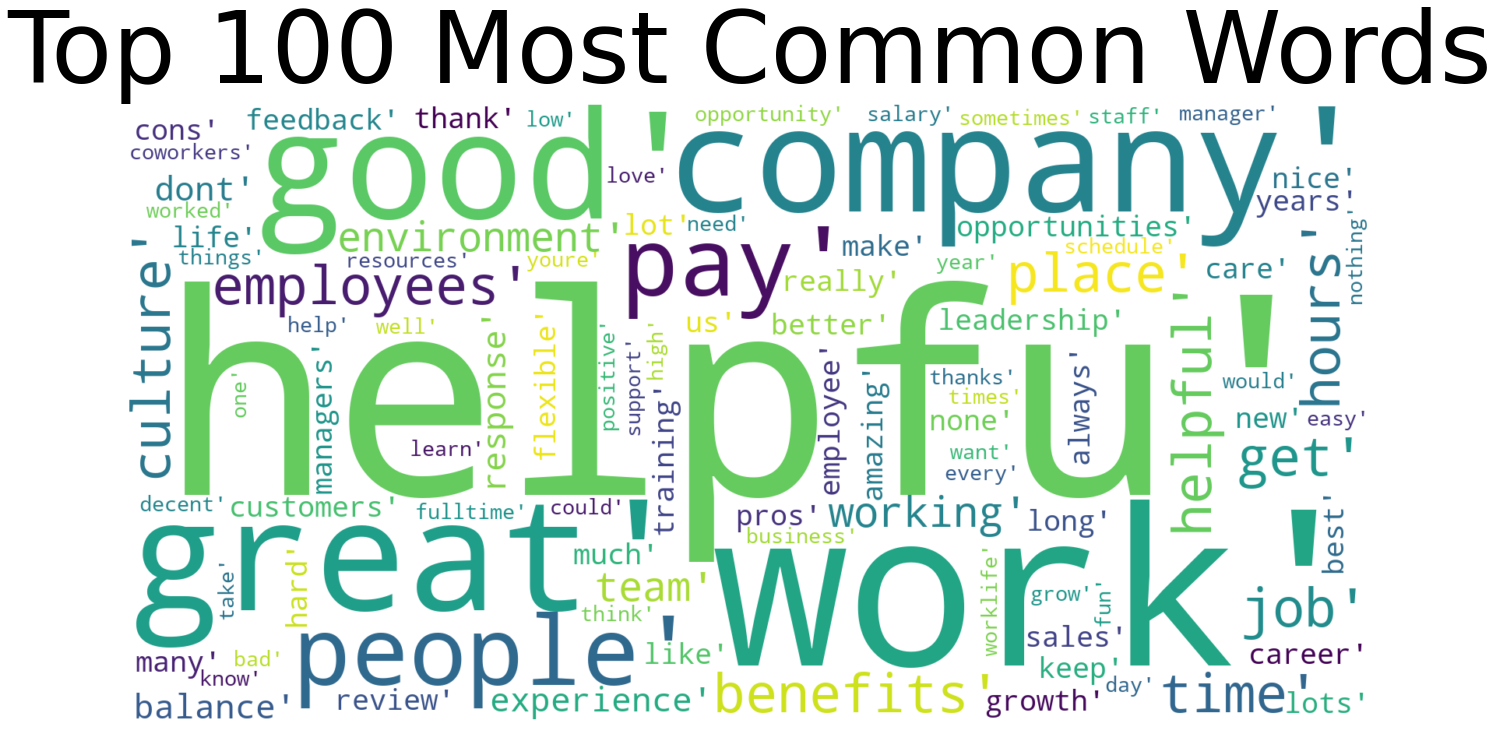

In [11]:
words = dfa['review_text']
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.savefig('word_cloud_all.png')
plt.show();


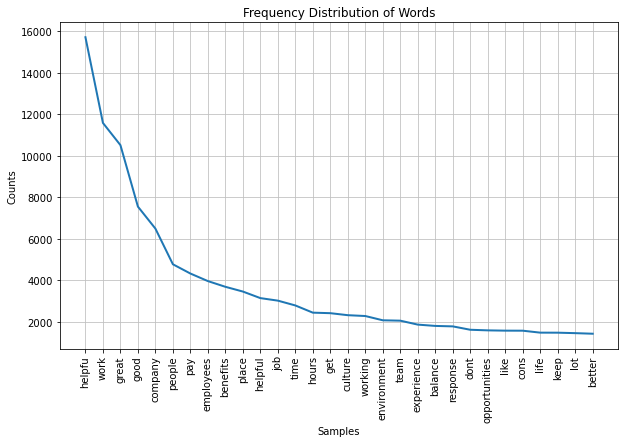

In [12]:
processed_corpus = list(dfa['review_text']) 

def plot_frequency(data):
    """
    Ploting words frequency distribution
    from corpus. data should be list of lists with strings
    """
    words_lst = []
    for review in data:
        words_lst.extend(review)

    fdist = FreqDist(words_lst)
    plt.figure(figsize=(10,6))
    fdist.plot(30, title = "Frequency Distribution of Words")
    plt.show()  
    
plot_frequency(processed_corpus)

<a name="step3"></a>
## Exploring the Text by Target Category 

Now that I have a general idea of what is going with the whole of the dataset I can look at my target catagories to figure out whether it would be best to use stemming or lemmitization, as well as take alook at my class balance. 

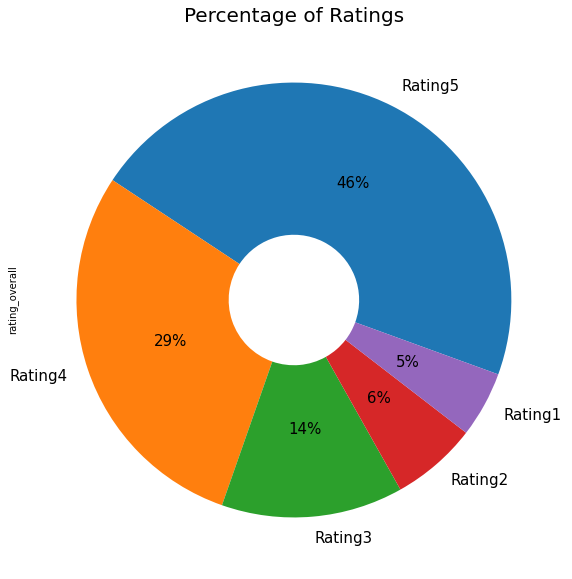

In [13]:
#Runs normalize counts of reviews by category in pie chart form
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings', fontsize=20)
df.rating_overall.value_counts().plot(kind='pie', labels=['Rating 5', 'Rating 4', 'Rating 3', 'Rating 2', 'Rating 1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15}); 
#plt.savefig('rating_dist_donut.png')

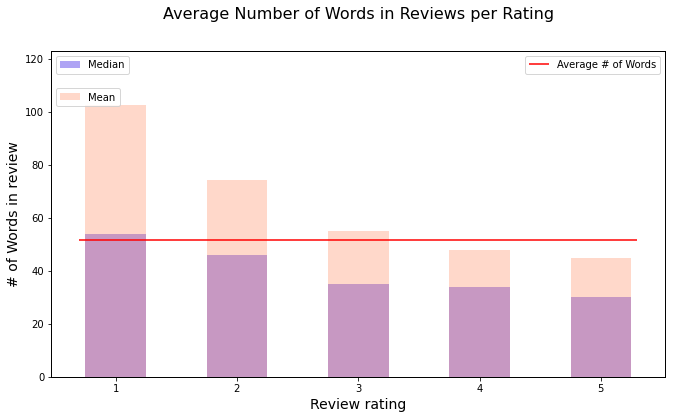

In [14]:
#Look at the average number of words by rating cat
mean = df[['rating_overall', 'words']].groupby('rating_overall')['words'].mean()
median = df[['rating_overall', 'words']].groupby('rating_overall')['words'].median()
mean_data = df.words.mean()

score = np.arange(1,6)
fig, ax = plt.subplots(figsize=(11,6))
ax2 = ax.twinx() #set ax2 on same x axis as ax
ax3 = ax.twinx() #same as above, for hline
width = 0.5
ax.bar(x=score, height=median, width=width,
       label="Median", color="mediumslateblue", alpha=0.6)
ax2.bar(x=score, height=mean, width=width,
        label="Mean", color="coral", alpha=0.3)
ax3.hlines(mean_data, .7 ,5.3, colors="red", label="Average # of Words")
ax.set_ylim(0,1.2*mean.max())
ax2.set_ylim(0,1.2*mean.max())
ax3.set_ylim(0,1.2*mean.max())
ax2.yaxis.set_visible(False) #hide the 2nd axis
ax3.yaxis.set_visible(False)
ax.legend(bbox_to_anchor=(0,0,1,1), loc="upper left")
ax2.legend(bbox_to_anchor=(0,-.1,1,1), loc="upper left")
ax3.legend(bbox_to_anchor=(0,0,1,1), loc="upper right")
ax.set_ylabel("# of Words in review", size=14)
ax.set_xlabel("Review rating", size=14)
plt.title("Average Number of Words in Reviews per Rating", size=16, y=1.08)
plt.legend()
#plt.savefig('avg_word_rating.png')
plt.show(); 



In [15]:
#Create dataframes for each rating using stem catagory
corpus_1 = df[df['rating_overall']==1.]
corpus_2 = df[df['rating_overall']==2.]
corpus_3 = df[df['rating_overall']==3.]
corpus_4 = df[df['rating_overall']==4.]
corpus_5 = df[df['rating_overall']==5.]

corpus_by_class = [corpus_1, corpus_2, corpus_3, corpus_4, corpus_5]

data_class = [corpus['stem'] for corpus in corpus_by_class] 

In [16]:
#Creates function that produce the frequency distribution of the data
def freq_wrds_class(data, n = 20, top= True):
    
    """
    Returns list of 2 tuples that represents frequency
    of words in document
    
    data - Series with string data
    n - number of most common words to show
    """
    
    protc_data = list(data) 
    
    total_vocab = set()
    for comment in protc_data:
        total_vocab.update(comment)
    
    if top:
        print('Total words in vocab : {}'.format(len(total_vocab)))
        #print (30*'-')
        #print('Top {} most frequent words:'.format(n))
        flat_data = [item for sublist in protc_data for item in sublist]
        freq = FreqDist(flat_data)
        
        return freq.most_common(n)
    
    flat_data = [item for sublist in protc_data for item in sublist]
    freq = FreqDist(flat_data)
    return freq.most_common(len(total_vocab))

In [17]:
#Visualizes the frequency distribution
def visual_freq(data):
    """
    data - list of pandas.core.series.Series
           with text in each row 
    """
    
    class_freq = [freq_wrds_class(d_class) for d_class in data]
    bar_count_bar_wrds = [([x[1] for x in clas], [x[0] for x in clas]) for clas in class_freq]
    
    # set the color of our bar graphs
    color = cm.plasma(np.linspace(.8,.16, 30))
    
    fig, ax = plt.subplots(len(bar_count_bar_wrds), 1, figsize=(2*len(bar_count_bar_wrds), 3*len(bar_count_bar_wrds)))
    i = 0
    
    for b_c_b_v in bar_count_bar_wrds:
        bar_count, bar_wrds = b_c_b_v
        ax[i].bar(bar_wrds, bar_count, color=color)
        ax[i].title.set_text('{} star rating'.format(i+1))
        i+=1
    
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=60)

    plt.tight_layout(pad=0) 
    #plt.savefig('freqchart.png')
    
    plt.show()

Total words in vocab : 3784
Total words in vocab : 3588
Total words in vocab : 4293
Total words in vocab : 5622
Total words in vocab : 6307


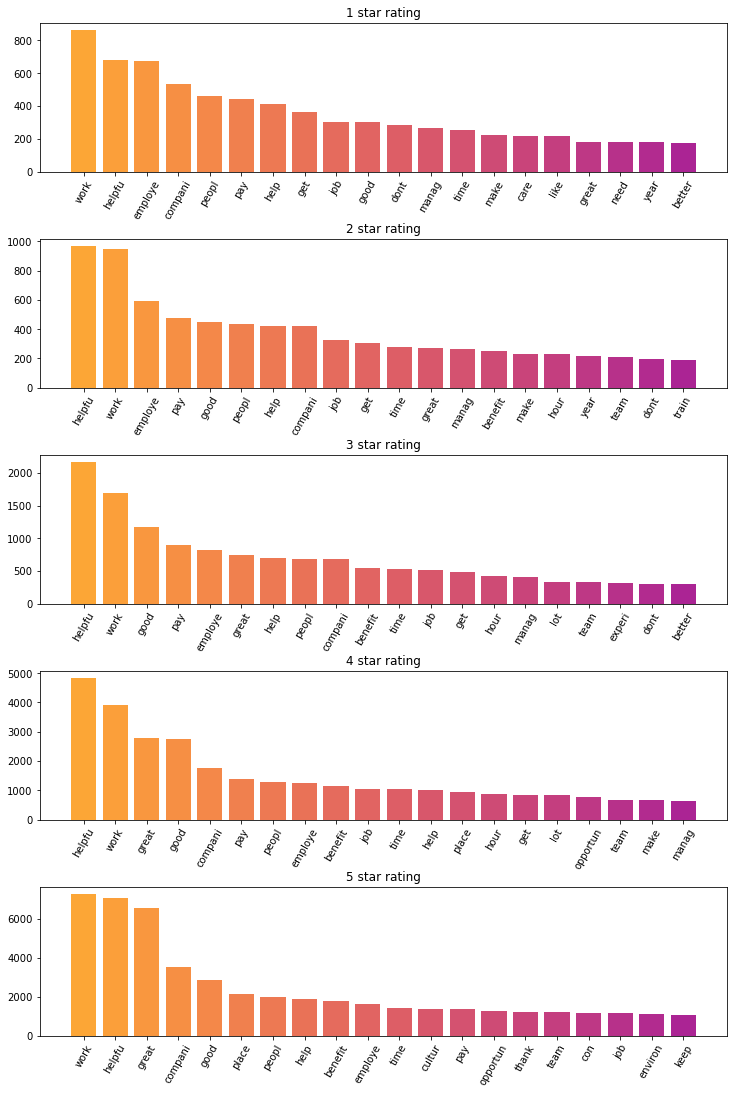

In [18]:
#Runs function
visual_freq(data_class) 

>After running the above to functions on both stemmed and lemmed data, I have decided to moved forward with stemmed data which I believe better accounts for misspellings in the text.

<a name="step4"></a>
### Looking at NGrams 

Hvaing seen overlap I will now take a look at whether bigrams or ngrams will be better for differentiating between classes.

In [19]:
#Calls bigram functions
bigram_measures = nltk.collocations.BigramAssocMeasures()

#Creates list of words
tokens_by_class = []
for w_class in data_class:
    flat_data = [item for sublist in w_class for item in sublist]
    tokens_by_class.append(flat_data)  
    
#Ties words to bigram finder
bigram_finder = BigramCollocationFinder.from_words(tokens_by_class[0]) 

#Calls functions onto text
corpus_scored = bigram_finder.score_ngrams(bigram_measures.raw_freq)

In [20]:
#Creates Function to Visualize NGrams
def visualize_w_grams(data_token_class, n=2):
    for i,tokens_by_class in enumerate(data_token_class):
        bigrams_series = (pd.Series(nltk.ngrams(tokens_by_class, n)).value_counts())[:20]
        bigrams_series.sort_values().plot.barh(color=cm.plasma(np.linspace(.4,.8, 30)), width=.9, figsize=(11, 4))
        plt.title('20 Most Frequently Occurring in {}-grams of class {}-star'.format(n,i+1), fontsize=18)
        plt.ylabel('{}-gram'.format(n), fontsize=18)
        plt.xlabel('Number of Occurances', fontsize=18)
        #plt.savefig('ngramscharts.png')
        plt.show()

In [21]:
#Calls Ngrams function on each category 
rat_1 = (pd.Series(nltk.ngrams(tokens_by_class[0], 3))).values
rat_2 = (pd.Series(nltk.ngrams(tokens_by_class[1], 3))).values
rat_3 = (pd.Series(nltk.ngrams(tokens_by_class[2], 3))).values
rat_4 = (pd.Series(nltk.ngrams(tokens_by_class[3], 3))).values
rat_5 = (pd.Series(nltk.ngrams(tokens_by_class[4], 3))).values

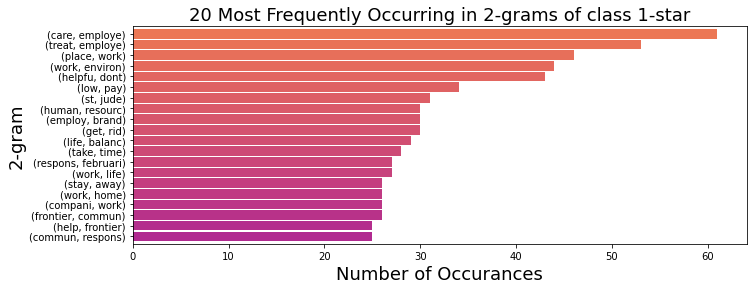

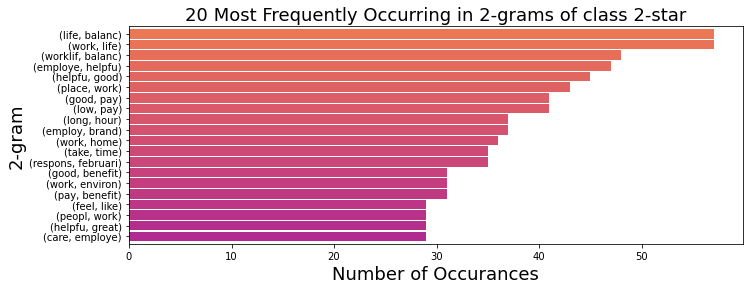

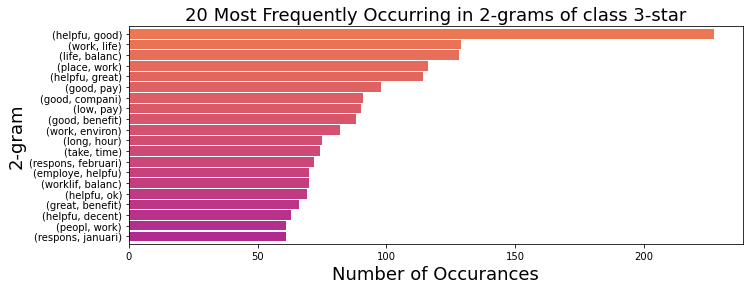

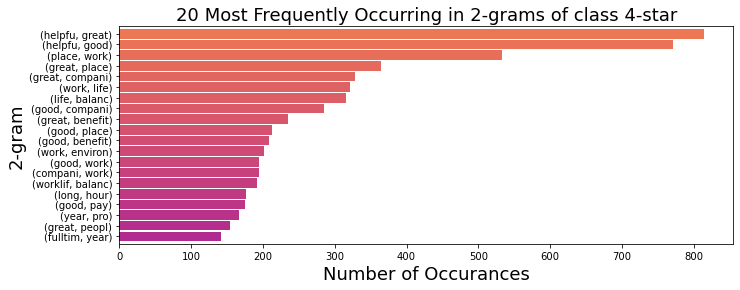

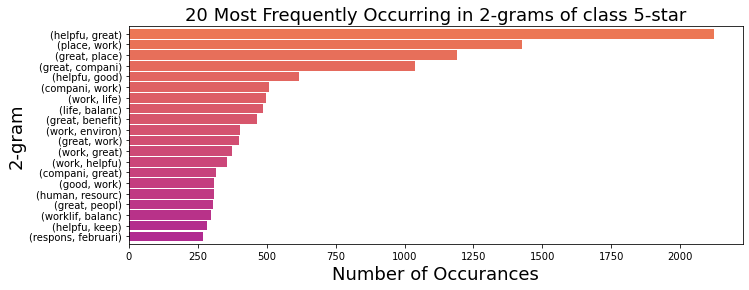

In [22]:
#Runs visualization function on each rating group
visualize_w_grams(tokens_by_class)

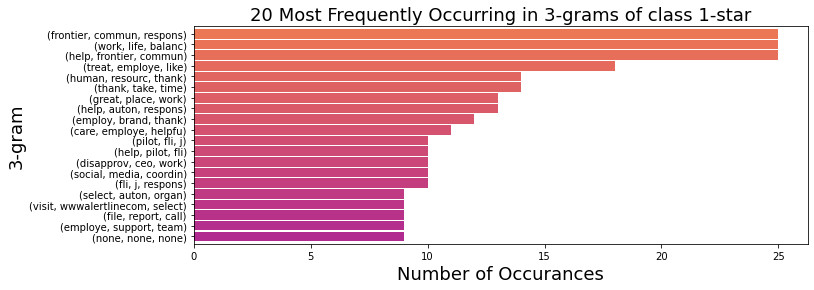

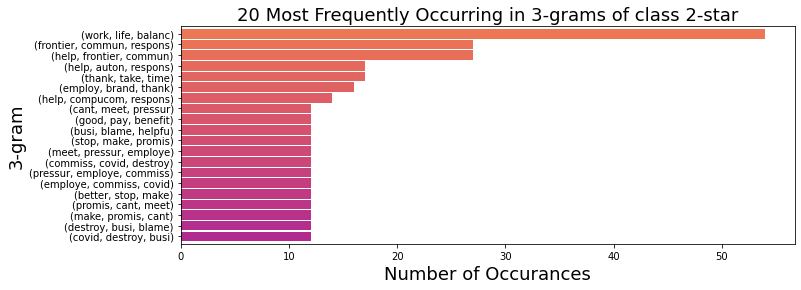

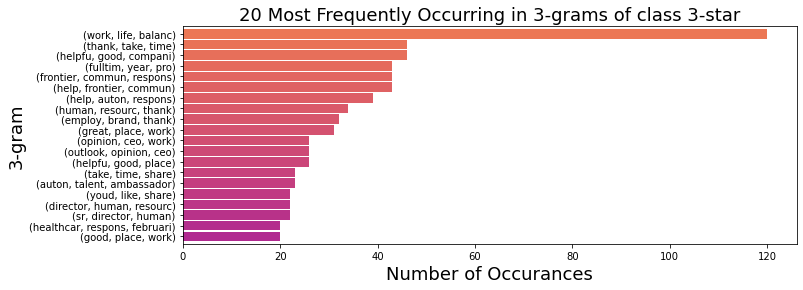

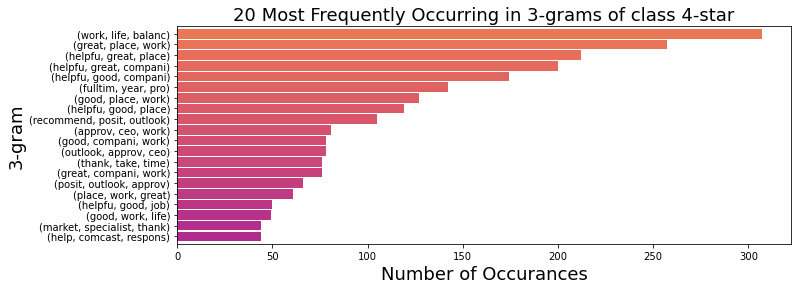

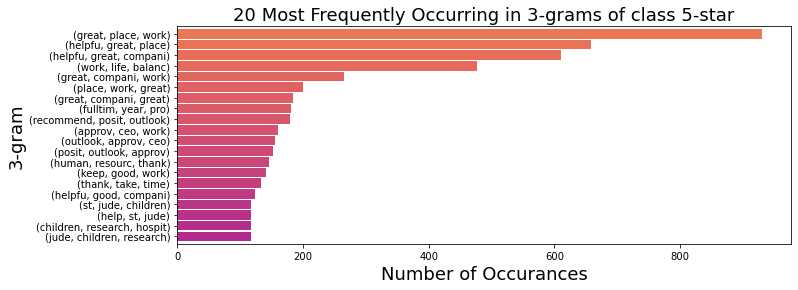

In [23]:
#Runs Ngram function on ngrams of 3 on each rating group
visualize_w_grams(tokens_by_class, n=3)

> Next I want to confirm once again that my classes are distinct enough using venn diagram. Based off the charts abonve I know I will be using bigrams and trigrams instead of unigrams but the venn diagrams will confirm i have enough unique words.

In [24]:
#Calls freq distribution function on groups of words
class_wocab = [freq_wrds_class(data, top = False) for data in data_class]

#Makes a list out of word groups 
words_by_class = []
for data_class in class_wocab:
    words_by_class.append([t[0] for t in data_class])

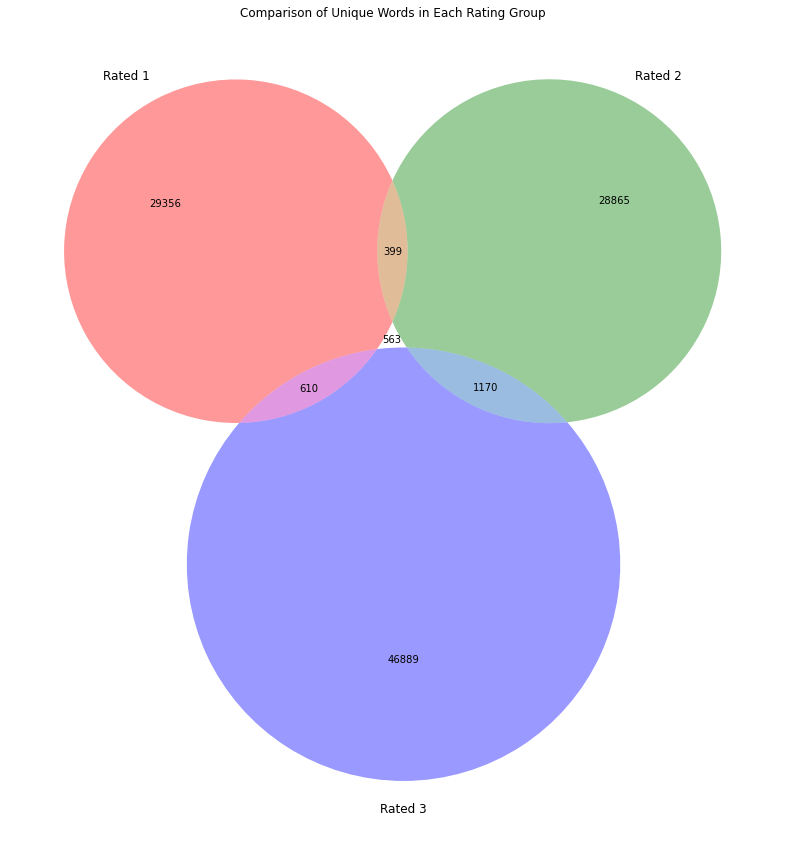

In [25]:
#Plots a Venndiagram of the First three rating groups
plt.figure(figsize=(15,15), facecolor='w')
venn3([set(rat_1), set(rat_2), set(rat_3)], set_labels = ('Rated 1', 'Rated 2', 'Rated 3'))
plt.title('Comparison of Unique Words in Each Rating Group')
# plt.savefig('../images/venn.png')
plt.show()

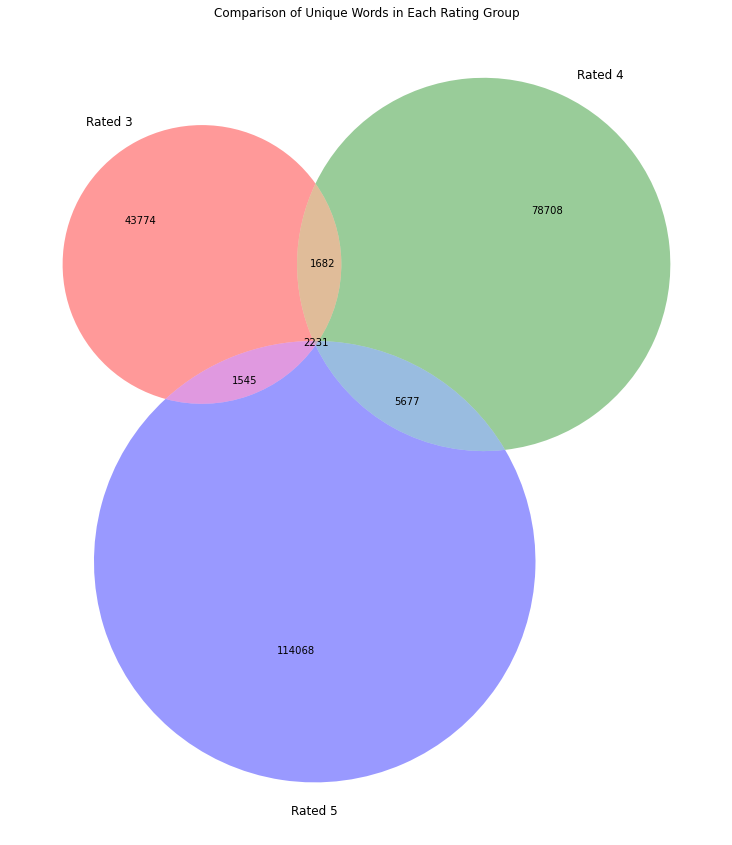

In [26]:
#Plots a Venn diagram of the last three rating groups
plt.figure(figsize=(15,15), facecolor='w')
venn3([set(rat_3), set(rat_4), set(rat_5)], set_labels = ('Rated 3', 'Rated 4', 'Rated 5'))
plt.title('Comparison of Unique Words in Each Rating Group')
# plt.savefig('../images/venn.png')
plt.show()

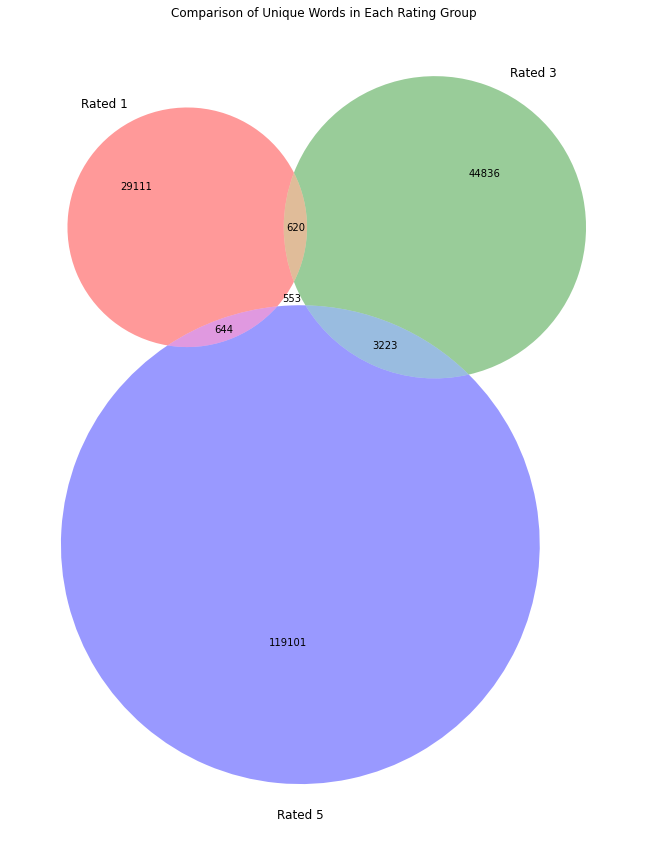

In [27]:
#Plots a venn diagram of first, third, and 5th rating group 
plt.figure(figsize=(15,15), facecolor='w')
venn3([set(rat_1), set(rat_3), set(rat_5)], set_labels = ('Rated 1', 'Rated 3', 'Rated 5'))
plt.title('Comparison of Unique Words in Each Rating Group')
#plt.savefig('venn.png')
plt.show()

<a name="step5"></a>
### Sentiment Feature Creation 

The last thing I want to do is add a sentiment column column to the dataset and take a look at 

In [28]:
#Map the stem column
df['stem_str'] = [' '.join(map(str,l)) for l in dfa['stem']] 

#Use package to apply sentiments
df['sentiment'] = df['stem_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

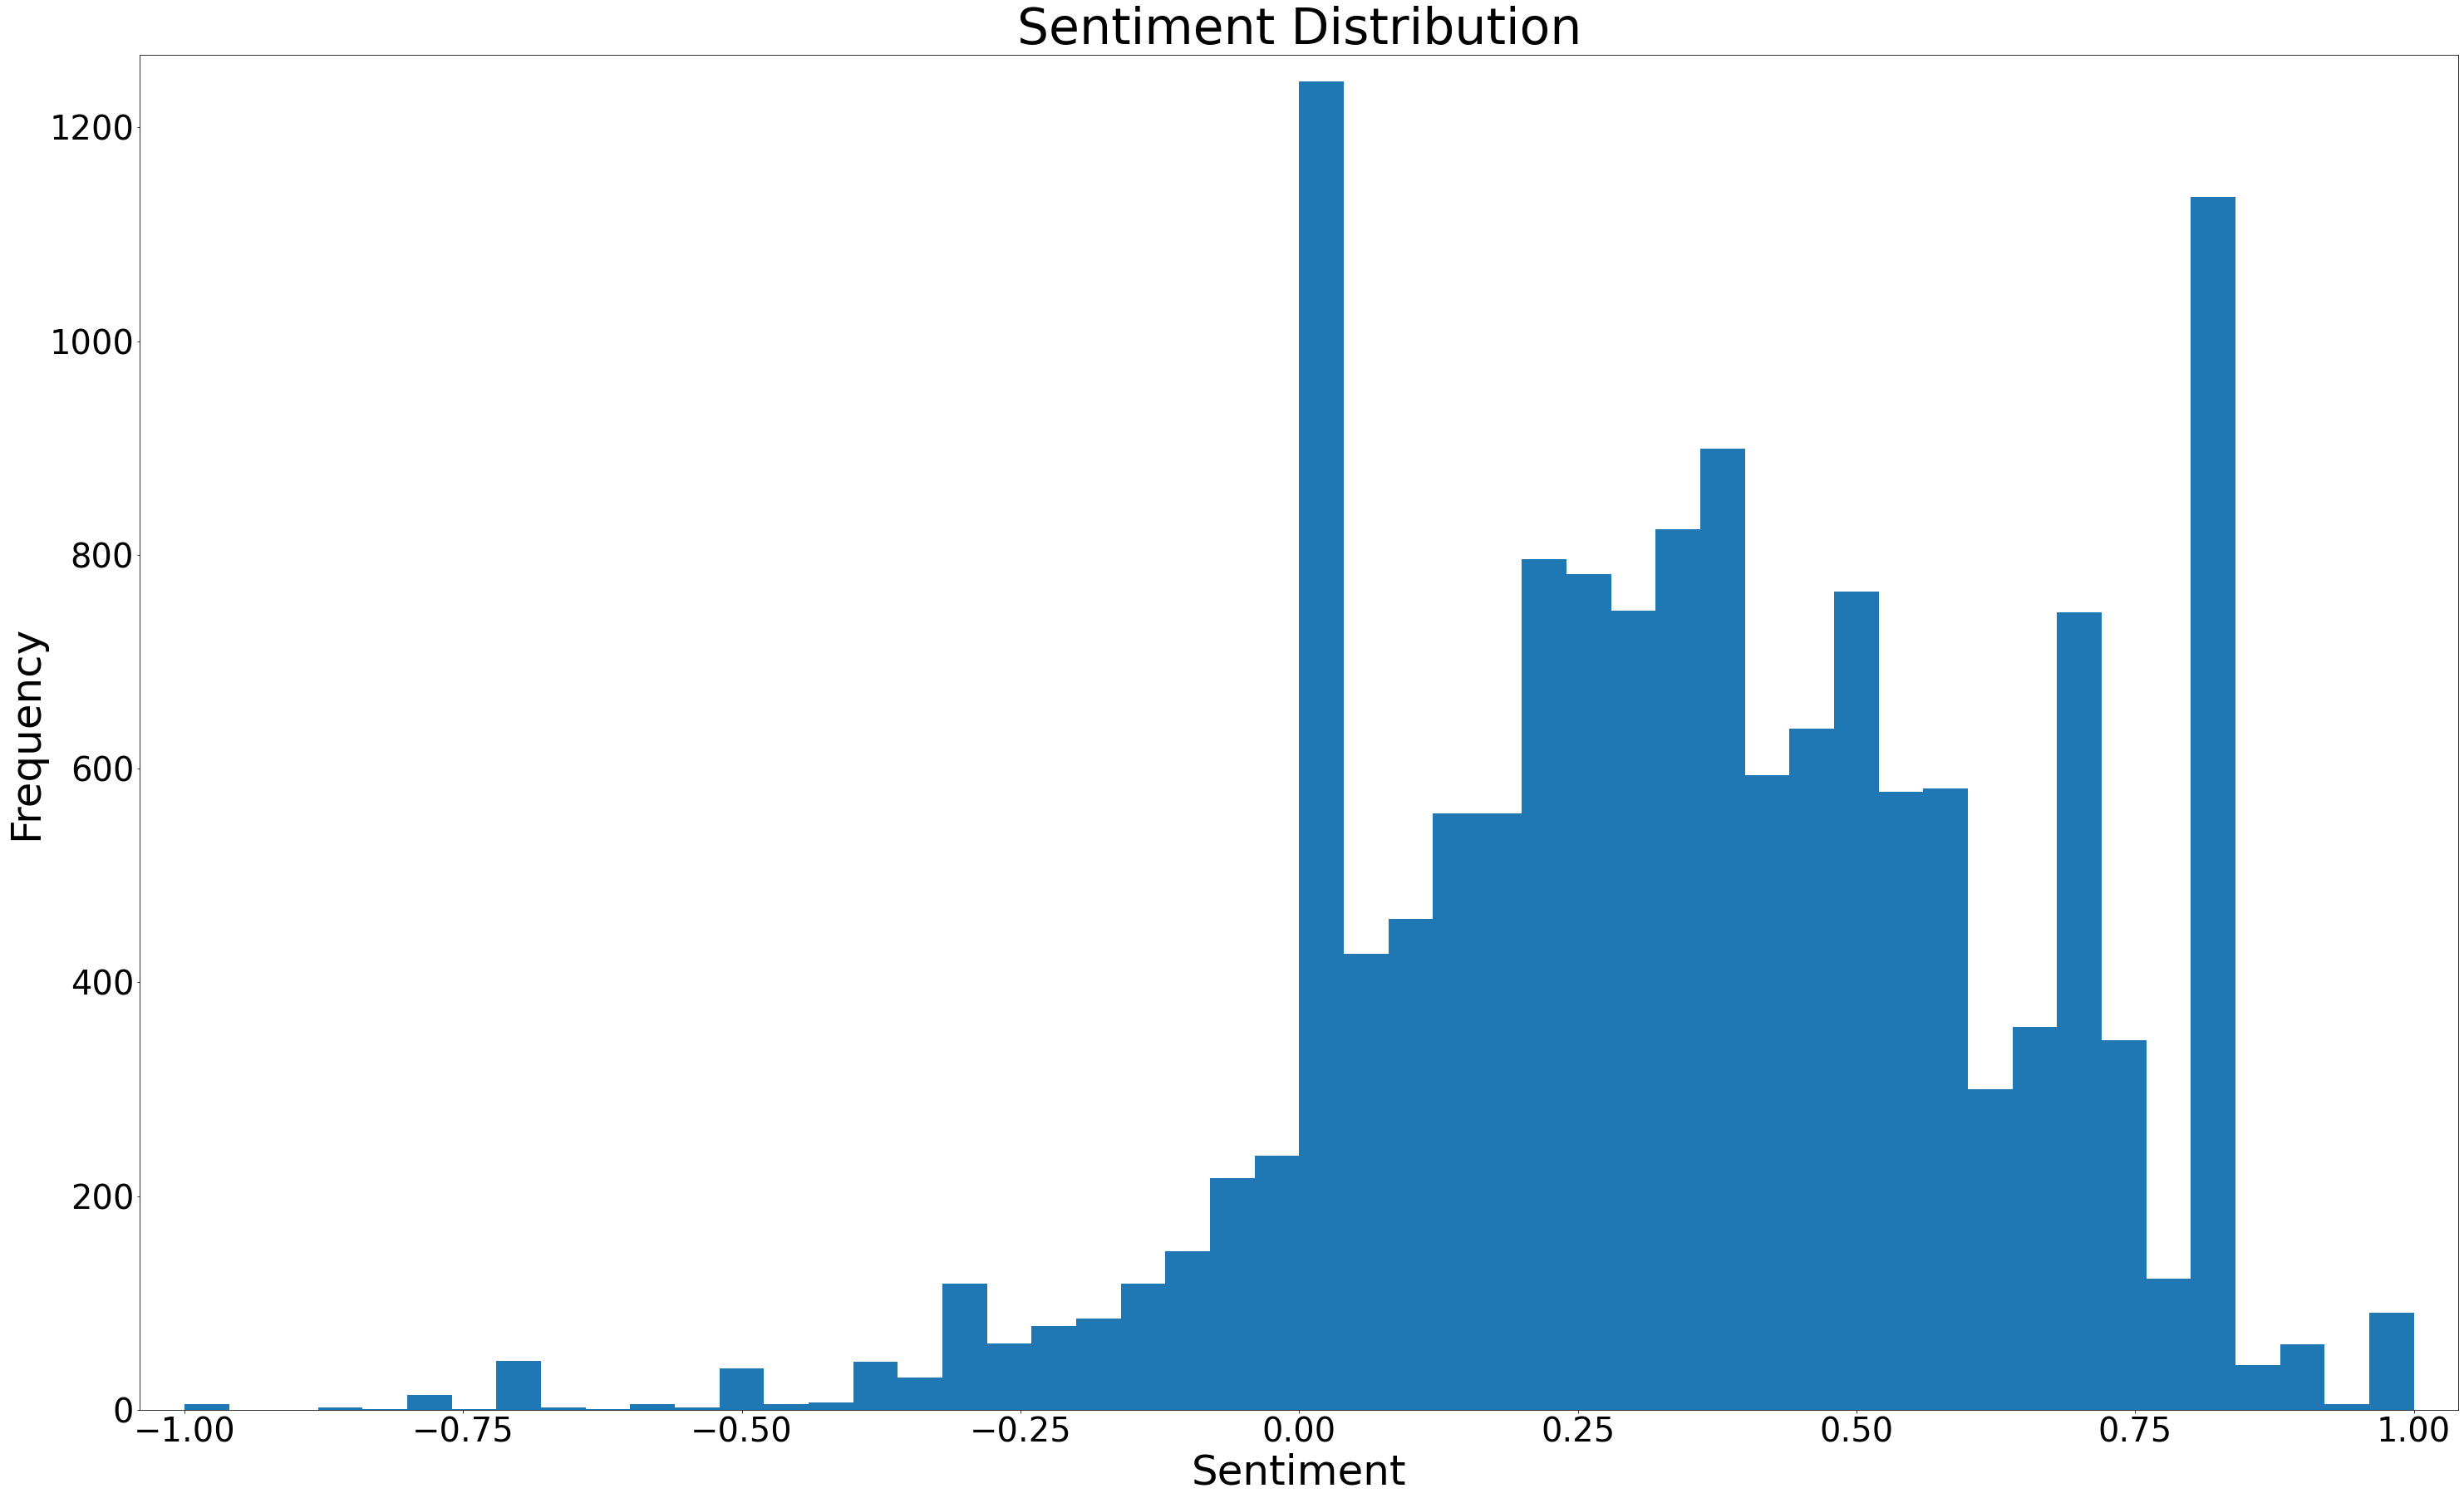

In [29]:
#Plot Sentiment Distribution
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

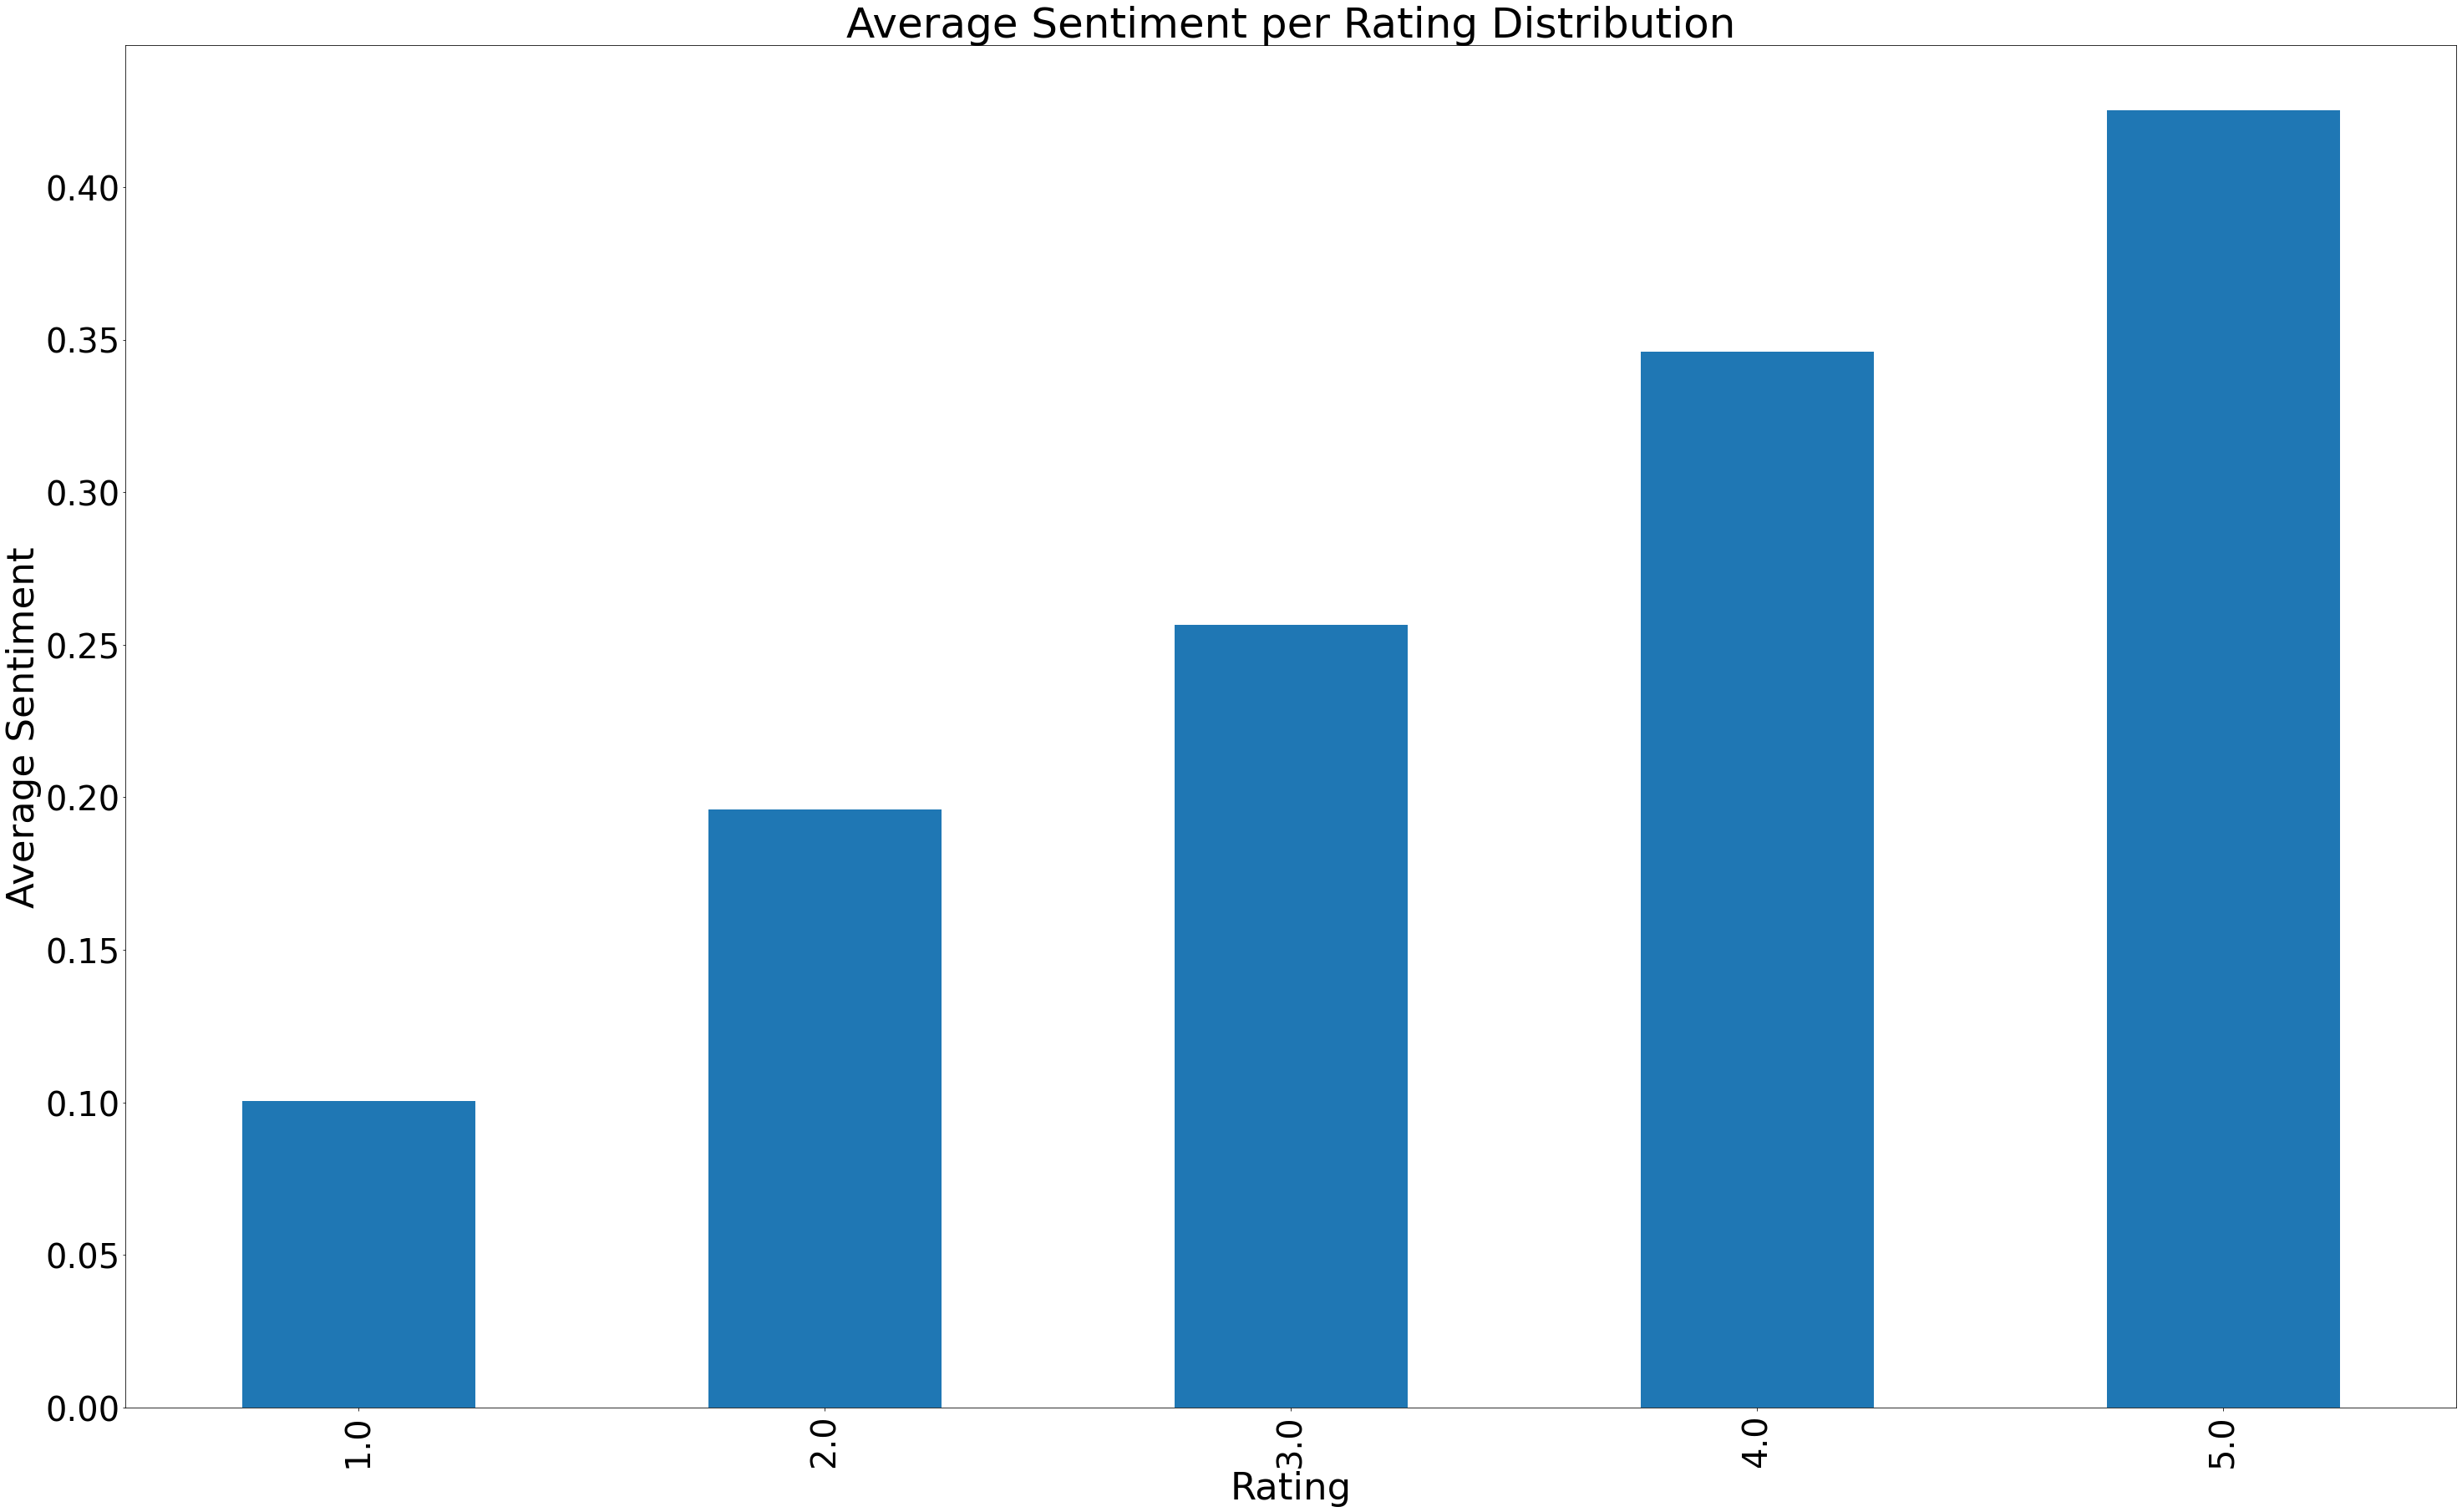

In [30]:
#Plot Average sentiment distribution
polarity_avg = df.groupby('rating_overall')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Rating Distribution', fontsize=50)
plt.show()

In [31]:
df.head(1)

,rating_overall,employee_title_title_known,employee_title_title_unknown,employee_status_current_employee,employee_status_former_employee,employee_status_unknown_status,helpful_helpful,helpful_not_helpful,recommends_does_not_recommend,recommends_recommends,...,adv,verb,characters,tokens,words,sentences,avg_word_len,avg_sent_len,stem_str,sentiment
0,5.0,1,0,1,0,0,0,1,0,1,...,0.181818,0.181818,94,11,17,3,5.529412,5.666667,great alway room improv everybodi work togeth con love job helpfu,0.65


<a name="step6"></a>
## Save Dataset

In [32]:
import pickle 
df.to_pickle('df_processed_full.pickle') 


In [33]:
df.to_csv('df_processed_full.csv')